In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import logging
import glob
import random
import pydicom
import json
import PIL

from tqdm import tqdm

sys.path.append('../')
from rsna import utils

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
! ls /mirco-kaggle/rsna

GCP Credits Request Link - RSNA.txt  stage_1_test_images_dcm_dev
all.zip				     stage_1_test_images_jpg
label_map.pbtxt			     stage_1_test_images_jpg_dev
stage_1_detailed_class_info.csv      stage_1_train_images
stage_1_sample_submission.csv	     stage_1_train_images.zip
stage_1_test_images		     stage_1_train_images_jpg
stage_1_test_images.zip		     stage_1_train_labels.csv


In [6]:
! pwd

/home/ubuntu/kaggle-rsna/notebooks


In [13]:
tfrec_path = "../ml/v2/pred/pred.tfrec"

# Submission file

In [14]:
label_map = {0: 'other', 1: 'high_density'}

In [87]:
def _load_from_tfrec(tfrec_path, label_map, score_threshold=0.5):

    detections = {}
    
    for string_record in tf.python_io.tf_record_iterator(path=tfrec_path):
        
        example = tf.train.Example()
        example.ParseFromString(string_record)

        patientId = example.features.feature["image/filename"].bytes_list.value[0].decode("utf-8")
        filename = patientId
        patientId = os.path.basename(patientId).split(".jpg")[0]

        height = example.features.feature["image/height"].int64_list.value[0]
        width = example.features.feature["image/width"].int64_list.value[0]

        detected_labels = example.features.feature["image/detection/label"].int64_list.value
    
        frame_detections = []
        for i, label in enumerate(detected_labels):
            
            xmin = example.features.feature[f"image/detection/bbox/xmin"].float_list.value[i]
            xmax = example.features.feature[f"image/detection/bbox/xmax"].float_list.value[i]
            ymin = example.features.feature[f"image/detection/bbox/ymin"].float_list.value[i]
            ymax = example.features.feature[f"image/detection/bbox/ymax"].float_list.value[i]

            score = example.features.feature["image/detection/score"].float_list.value[i]

            if score < score_threshold:
                continue

            frame_detections.append(
                dict(
                    name=label_map[label],
                    xmin=round(xmin * width),
                    xmax=round(xmax * width),
                    ymin=round(ymin * height),
                    ymax=round(ymax * height),
                    score=score,
                )
            )

        detections[patientId] = frame_detections

    return detections

In [88]:
detections = _load_from_tfrec(tfrec_path=tfrec_path, label_map=label_map)

### plotting random sample

In [173]:
from PIL import ImageOps

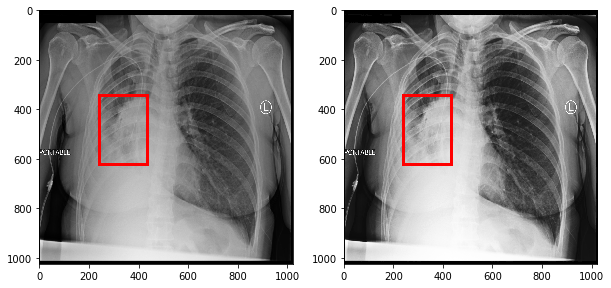

In [195]:
source_id, boxes = random.sample(detections.items(), 1)[0]
source_id
image = PIL.Image.open(os.path.join("/mirco-kaggle/rsna/stage_1_test_images_jpg/", source_id + ".jpg"))
boxes

fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(image, cmap='gray')
axes[1].imshow(ImageOps.equalize(image), cmap='gray')

for ax in axes:
    for box in boxes:
        if not box['score'] > 0.5:
            continue
        rect = plt.Rectangle(
            (box['xmin'], box['ymin']), box['xmax'] - box['xmin'], box['ymax'] - box['ymin'],
            fill=None, edgecolor="red", linewidth=3)
        ax.add_patch(rect)

### making submission

In [168]:
def make_submission_string(b):
    bbox = utils._bbox_convert_to_min_size(**b)
    return f"{round(b['score'], 2)} {bbox['xmin']} {bbox['ymin']} {bbox['width']} {bbox['height']}"
    
def f(v):
    submission_strings = []
    for b in v:
        submission_strings.append(make_submission_string(b))
    return " ".join(submission_strings)

In [93]:
d = [{'patientId':k, 'PredictionString': f(v)} for k, v in detections.items()]

In [94]:
dd = pd.DataFrame(d).loc[:, ['patientId', 'PredictionString']]

In [95]:
dd.to_csv("v2_7269_c0p5.csv", sep=",", index=False)
dd

,patientId,PredictionString
0,0e5397bc-f36c-4427-89f7-d95f31661c8a,
1,0fc4edec-08ea-4cd4-bf21-a6319ef0b44d,0.79 93 292 287 485 0.63 532 324 243 500
2,0124882b-de2f-4023-985f-debb74aa6ebb,0.77 220 542 220 285
3,214dcd68-4220-4010-8510-4c8eee830c70,
4,0d15858e-bd96-42cf-843e-57ff0c6e42a7,0.61 200 171 254 465 0.56 621 224 309 464
5,30363e8f-2955-4a45-b6e5-8e7146d6c243,0.66 592 396 250 210
6,125a4350-c49f-4056-bfc1-d016c68a1159,
7,13fce2c5-6834-485f-8280-c3b0c1b952b5,0.61 647 163 241 545 0.57 274 381 205 274
8,2a689cee-3fa4-405a-98de-da24278e7d33,
9,02bc87cb-6660-4faa-97e4-4de01cb640a4,0.61 616 458 245 475 0.51 270 567 192 282
